<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Computer%20Vision/models/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
from tensorflow import keras

# Define the stem

The stem is the part of the model that extracts coarse-level features of the input image.

In [2]:
def stem(inputs):
  '''
  Build the stem component.

  inputs: input vector
  '''
  x = keras.layers.Conv2D(filters=64,
                          kernel_size=3,
                          strides=1,
                          padding="same",
                          activation="relu")(inputs)

  return x

# Define the learner

In [3]:
def group(x, layers, filters):
  '''
  Build a (convolutional) group. Each group consists of one or more blocks.
  Each block contains a sequence of conv layers followed by a (max) pooling layer.
  The conv layers within each block has the same number of filters.

  x       : input to the group
  layers  : nr. of (convolutional) layers in the group
  filters : nr. of filters (or kernels) in each layer of the group
  '''

  # build the block of convolutional layers
  for i in range(layers):
    x = keras.layers.Conv2D(filters=filters,
                            kernel_size=3,
                            strides=1,
                            padding="same",
                            activation="relu")(x)

  # put a max pooling layer at the end of each block
  x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

  return x

The learner component performs detailed feature extraction and representational learning from the extracted coarse features.

In [4]:
def learner(x, group_info):
  '''
  Build the learner component of the VGG model.
  Each learner consist of one or more convolutional groups

  x             : coarse-level output feature map (from the stem component)
  group_info    : a list of group infos (nr. of layers & their nr. of filters)
  '''

  # build each group one by one
  for layers, filters in group_info:
    x = group(x, layers, filters)

  return x

# Define the task

The task component implements the classifier of the VGG model. It first flattens the input so that its fully connected layers can perform their task.

In [5]:
def task(x, classes, units=4096):
  '''
  Builds the task component of the VGG model.

  x           : input to the task component
  classes     : nr of classes each input image can belong to
  '''

  # flatten the input feature maps (coming from the learner component)
  x = keras.layers.Flatten()(x)

  # two dense layers (fully connected)
  x = keras.layers.Dense(units=units, activation="relu")(x)
  x = keras.layers.Dense(units=units, activation="relu")(x)

  # softmax layer to output probabilities
  x = keras.layers.Dense(classes, activation="softmax")(x)

  return x

# Putting all pieces together

In [6]:
# Meta-parameter: list of groups: number of layers and filter size
group_info = { 16 : [ (1, 64), (2, 128), (3, 256), (3, 512), (3, 512) ],		# VGG16
               19 : [ (1, 64), (2, 128), (4, 256), (4, 512), (4, 512) ] }		# VGG19

In [7]:
# define the input vector
inputs = keras.Input(shape=(224, 224, 3))

In [8]:
# the stem component
x = stem(inputs)

# the learner component; let's select the VGG16 specification
x = learner(x, group_info[16])

# the task component
outputs = task(x, 1000)

# create the VGG16 model
vgg16 = keras.Model(inputs=inputs, outputs=outputs, name="vgg")

In [9]:
# print a summary of the VGG16 model
vgg16.summary()

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                               

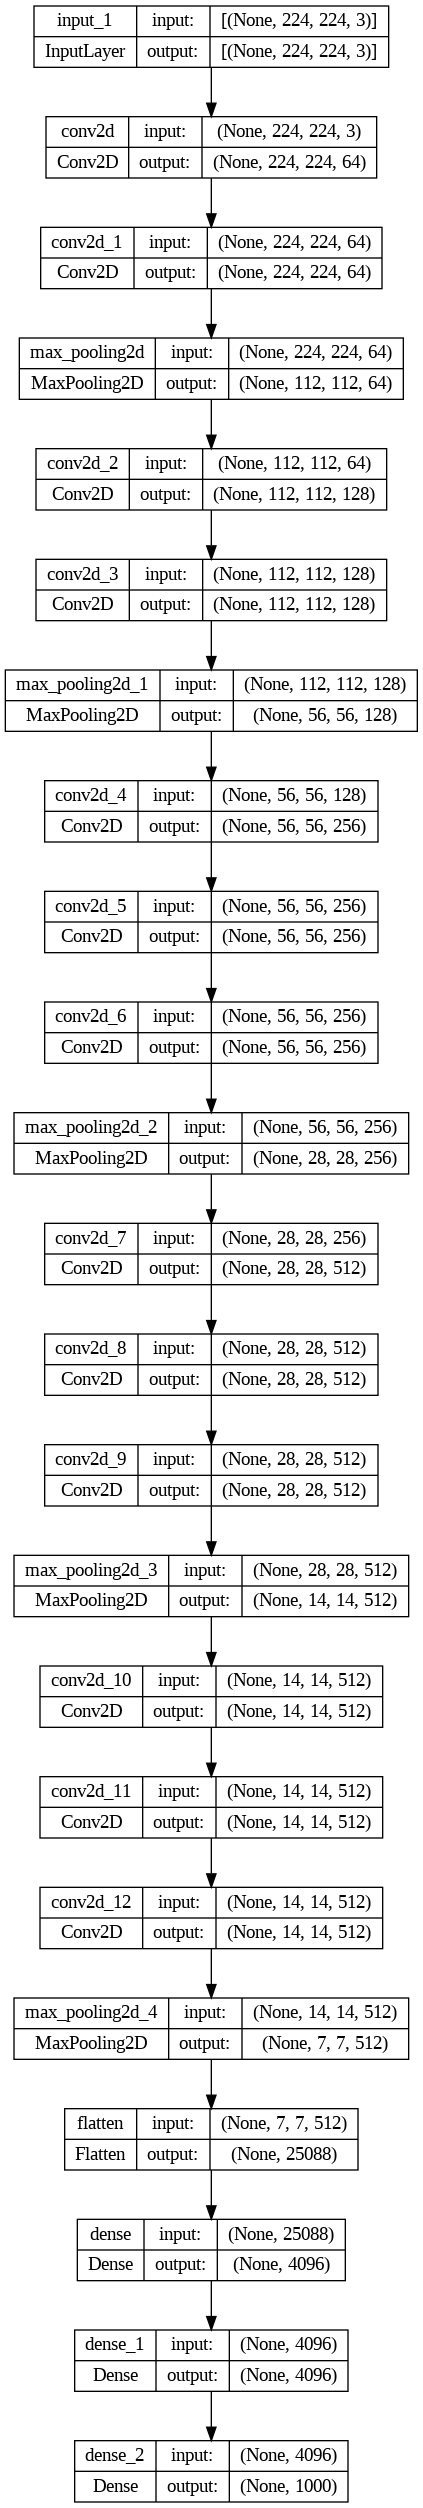

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(vgg16, to_file='model_plot.png', show_shapes=True, show_layer_names=True)